In [210]:
# Load modules
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter

In [211]:
# Load Major Salivary Tumor Listing data
salivary_df = pd.read_csv("SEEROutput.csv",low_memory=False)
# Look at data header
# display(salivary_df.head())
display(salivary_df.info())
display(salivary_df.columns)

small_df = salivary_df.sample(1000)
small_df.to_csv('output.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28030 entries, 0 to 28029
Data columns (total 64 columns):
 #   Column                                                     Non-Null Count  Dtype 
---  ------                                                     --------------  ----- 
 0   Patient ID                                                 28030 non-null  int64 
 1   Age recode with <1 year olds                               28030 non-null  object
 2   Sex                                                        28030 non-null  object
 3   Year of diagnosis                                          28030 non-null  int64 
 4   PRCDA 2020                                                 28030 non-null  object
 5   Race recode (W, B, AI, API)                                28030 non-null  object
 6   Origin recode NHIA (Hispanic, Non-Hisp)                    28030 non-null  object
 7   Site recode ICD-O-3/WHO 2008                               28030 non-null  object
 8   Behavior code IC

None

Index(['Patient ID', 'Age recode with <1 year olds', 'Sex',
       'Year of diagnosis', 'PRCDA 2020', 'Race recode (W, B, AI, API)',
       'Origin recode NHIA (Hispanic, Non-Hisp)',
       'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3',
       'Primary Site - labeled', 'Primary Site', 'Histologic Type ICD-O-3',
       'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
       'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Laterality',
       'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
       'ICD-O-3 Hist/behav, malignant', 'Histology recode - broad groupings',
       'Site recode ICD-O-3/WHO 2008 (for SIRs)',
       'Combined Summary Stage (2004+)', 'Summary stage 2000 (1998-2017)',
       'SEER Combined Summary Stage 2000 (2004-2017)',
       'SEER historic stage A (1973-2015)', 'RX Summ--Surg Prim Site (1998+)',
       'RX Summ--Scope Reg LN Sur (2003+)',
       'RX Summ--Surg Oth Reg/Dis (2003+)', 'RX Summ--Surg/Rad Seq',
       'Reason no can

# SEER Salivary Tumor Data Missing Values
Although it appears that there are minimal null values, this is likely due to the way that data have been logged. For each relevant column, we may need to address missing values individually. They may be logged as, for example, 'XX' or '99'. As such, we will always view unique values in each column before evaluations


# Data Cleaning: Categorical Adjustments and  Orders Including Histology and Grade 

In [283]:
# Select relevant columns for demographic analysis
age_colname = 'Age recode with single ages and 90+'
age_bin_colname = 'Age_Binned'
race_colname = 'Race recode (W, B, AI, API)'
sex_colname = 'Sex'
ses_colname = 'Median household income inflation adj to 2022'

demographic_columns = [age_colname,race_colname,sex_colname, ses_colname]

# Remove 'years'
salivary_df[age_colname] = salivary_df[age_colname].str.replace(' years','') 

# Organize age column as a categorical with numerical order
numerical_years = salivary_df[age_colname].str.extract(r'(\d+)').astype(float)
# print(numerical_years[0].unique())
# Input numerical age data into the dataframe
salivary_df['Numerical_Age'] = numerical_years


# Define 5-year bins from 0 to 90+, using float to allow for infinity in the final bin
bins = np.concatenate([np.arange(0, 95, 5), [np.inf]])  # Include infinity in the last bin

# Create labels for the bins, including '90+' for the last bin
labels = [f'{i}-{i+4}' for i in range(0, 90, 5)] + ['90+']

# Apply pd.cut to create the binned age categories
salivary_df[age_bin_colname] = pd.cut(salivary_df['Numerical_Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Check the unique values of the new binned age column
# print(salivary_df[age_bin_colname].unique())
# Create a mapping for values with leading zeros and handle special cases:
# - Convert '00' and '<1' to '≤1'
# - Remove leading zeros for values like '02', '03', etc.
# - Leave '90' as it is

sorted_ages = salivary_df[age_colname].unique()
age_mapping = {
    age: '≤1' if age == '00' or age == '<1' else (str(int(age)) if age.isdigit() and int(age) < 10 else age)
    for age in sorted_ages
}

# Replace values in the age column using the mapping
salivary_df[age_colname] = salivary_df[age_colname].replace(age_mapping)

# Get the sorted unique ages after the mapping has been applied
# Ensure '≤1' comes first by assigning key paramter = -1
# Otherwise: get rid of "+" at the end of 90
sorted_ages = sorted(
    salivary_df[age_colname].unique(),
    key=lambda x: (-1 if '≤1' in x else float(x.replace('+', '').replace('≤', '').replace('<', ''))) if x != '90+' else 90
)

# Convert the 'age_colname' column to categorical with sorted order
salivary_df[age_colname] = pd.Categorical(salivary_df[age_colname], categories=sorted_ages, ordered=True)

# Sex order
sex_order = ['Female','Male']

# Convert Sex column to reflect new order
salivary_df[sex_colname] = pd.Categorical(
    salivary_df[sex_colname], categories=sex_order, ordered=True
)

# Race order
race_order = sorted(salivary_df[race_colname].unique())

# Convert race column to reflect new world order
salivary_df[race_colname] = pd.Categorical(
    salivary_df[race_colname], categories=race_order, ordered=True
)

# display(salivary_df[age_colname].unique)


# SES
# sorted_ses_mapping = {
#     salivary_df[ses_colname].unique()
# }
# Define the order of categories, excluding the "Unknown/missing/no match/Not 1990-2022"
socioeconomic_order = [
    "<$40,000", "$40,000 - $44,999", "$45,000 - $49,999", "$50,000 - $54,999",
    "$55,000 - $59,999", "$60,000 - $64,999", "$65,000 - $69,999", "$70,000 - $74,999",
    "$75,000 - $79,999", "$80,000 - $84,999", "$85,000 - $89,999", "$90,000 - $94,999",
    "$95,000 - $99,999", "$100,000 - $109,999", "$110,000 - $119,999", "$120,000+"
]

# Change to categorical
salivary_df[ses_colname] = pd.Categorical(
    salivary_df[ses_colname],
    categories=socioeconomic_order,
    ordered=True
)
# display(salivary_df[ses_colname].unique())

# Categorize histological types - based on Baddour, JAMA Otolaryngol Head Neck Surg, 2015
mec_code = ['8430']
acc_code = ['8200']
adenocarcinoma_code = ['8140','8147','8290','8310','8410','8440','8480','8525','8550']
mixed_code = ['8980','8981']
rare_code = ['8012','8041','8082','8562','8982']

all_codes = mec_code + acc_code + adenocarcinoma_code + mixed_code + rare_code

# Function to map each code to a category
def categorize_histology(code):
    if code in mec_code:
        return 'Mucoepidermoid Carcinoma'
    elif code in acc_code:
        return 'Adenoid Cystic Carcinoma'
    elif code in adenocarcinoma_code:
        return 'Adenocarcinoma'
    elif code in mixed_code:
        return 'Mixed Subtypes'
    elif code in rare_code:
        return 'Other Rare Types'
    else:
        return 'Other'

# Extract 4 digit ICD-O-3 Code:
salivary_df['ICD-O-3 Code'] = salivary_df['ICD-O-3 Hist/behav'].str.extract(r'(\d{4})')

# Filter the DataFrame to include only rows where the 'ICD-O-3 Code' is in your list of codes
filtered_df = salivary_df[salivary_df['ICD-O-3 Code'].isin(all_codes)]

# Use assign to apply the histology categorization
filtered_df = filtered_df.assign(Histology=filtered_df['ICD-O-3 Code'].apply(categorize_histology))

# View the filtered DataFrame
# display(filtered_df[['ICD-O-3 Code', 'ICD-O-3 Hist/behav', 'Histology']])
# Define the ordered grade labels
grade_order = ['Grade I', 'Grade II', 'Grade III', 'Grade IV', 'Unknown']

# Grade Mapping
grade_mapping = {'Unknown':'Unknown',
 'Moderately differentiated; Grade II':'Grade II',
 'Well differentiated; Grade I': 'Grade I',
 'Poorly differentiated; Grade III': 'Grade III',
 'Undifferentiated; anaplastic; Grade IV': 'Grade IV'}

# apply mapping + convert to categorical
filtered_df['Grade Label'] = filtered_df['Grade Recode (thru 2017)'].map(grade_mapping)
filtered_df['Grade Label'] = pd.Categorical(filtered_df['Grade Label'], categories=grade_order, ordered=True)


Grade Label
Unknown      6566
Grade II     2920
Grade I      1858
Grade III    1527
Grade IV     1002
Name: count, dtype: int64


# Race v. Age; Sex v. Age; Income Distribution

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/64932703.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  racevage_histplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/64932703.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sexvage_countplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/64932703.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ses_countplot = sns.histplot(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/64932703.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ses_countplot.set_xticklabels(ses_countplot.get_xticklabels(),r

Text(0, 0.5, 'Number of Cases')

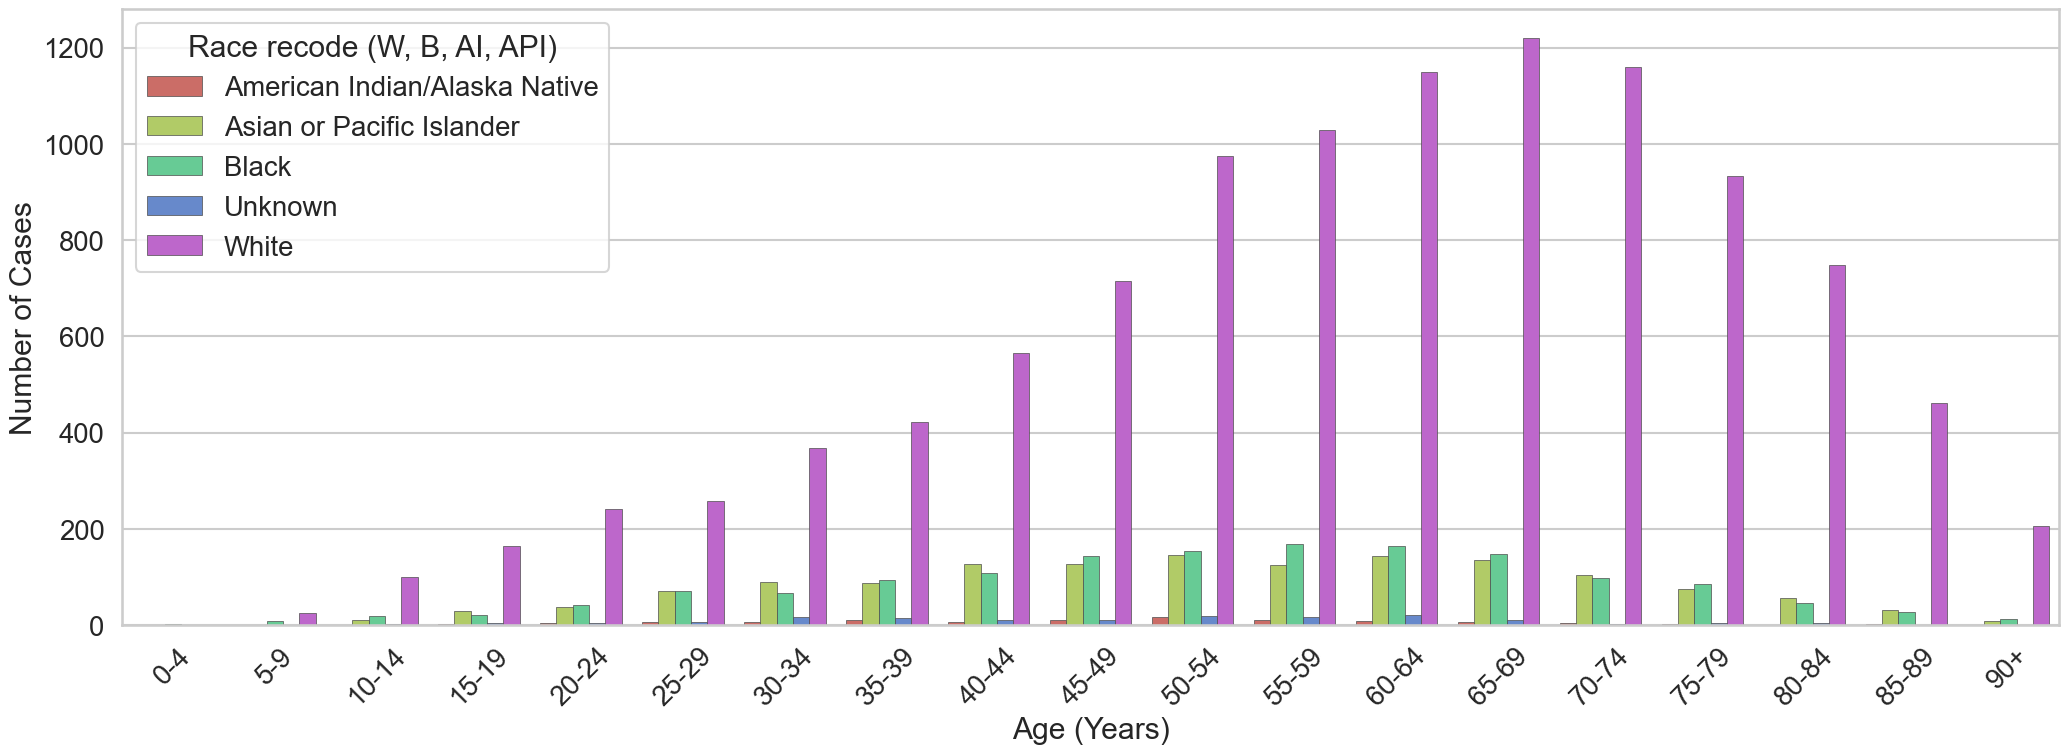

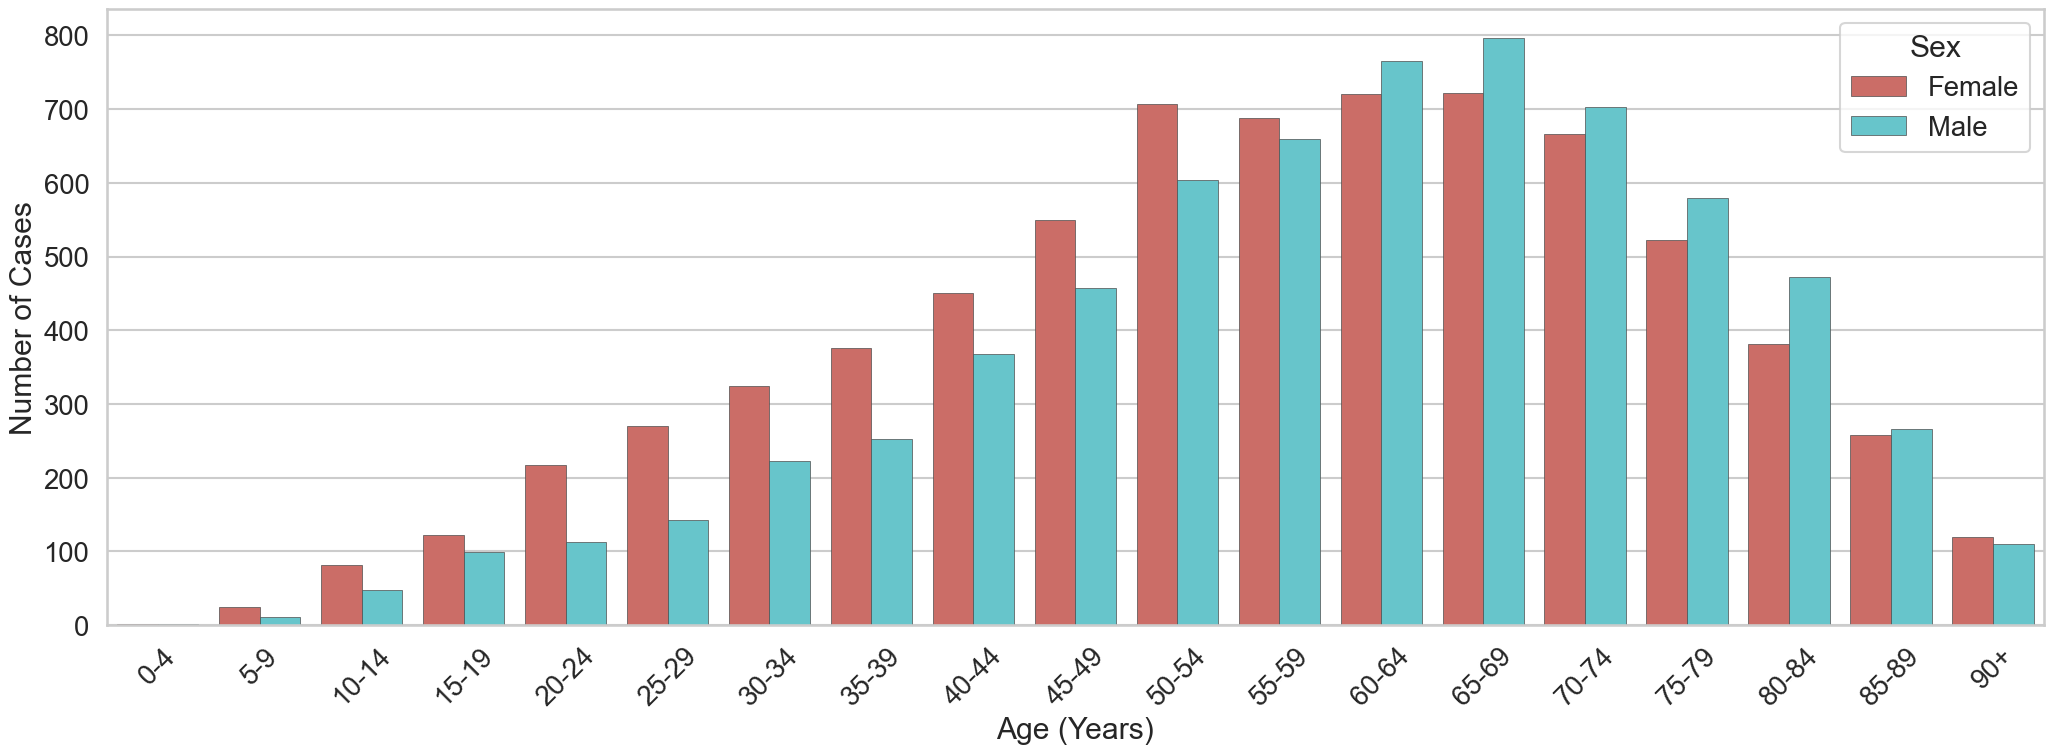

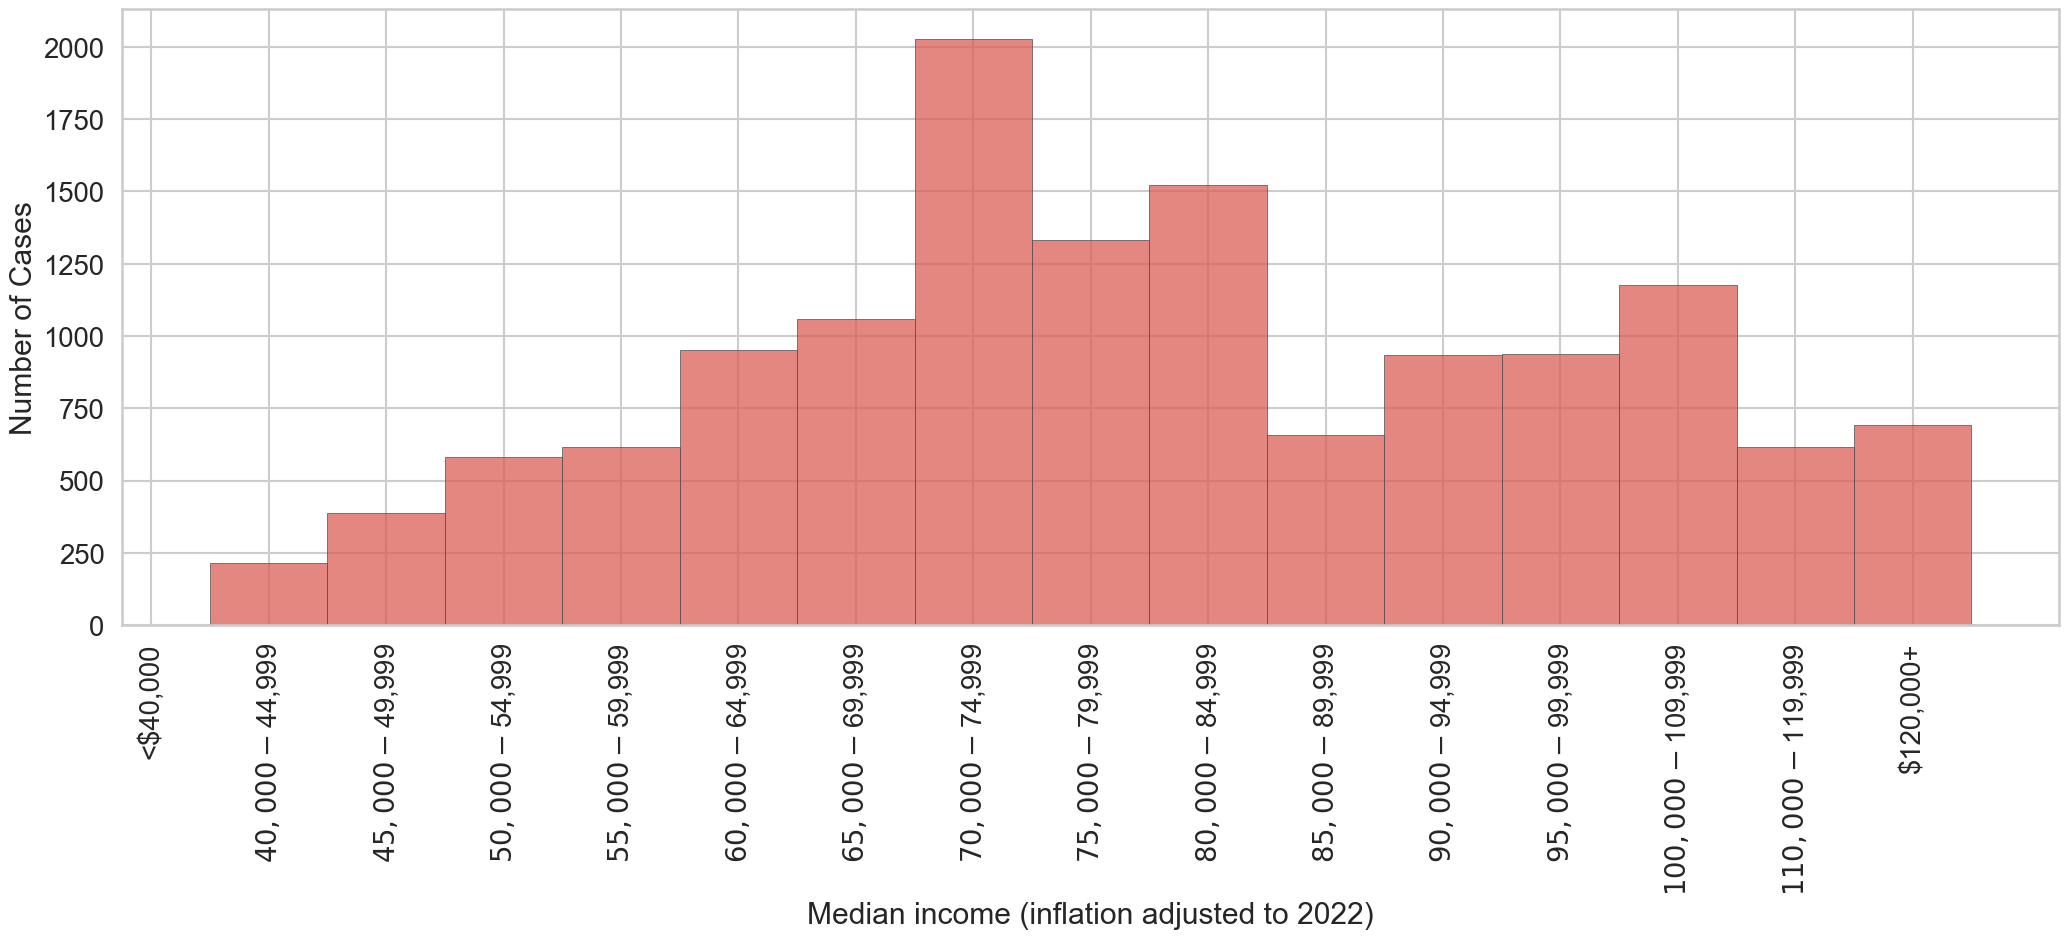

In [284]:
# Plot - countplot
sns.set_context('talk',font_scale=1.2)
sns.set_palette('hls')

# Race vs. Age
plt.figure(figsize=(25, 8))
racevage_histplot = sns.countplot(
    data=filtered_df,
    x=age_bin_colname,
    hue=race_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)
x_labels = racevage_histplot.get_xticklabels()

# Rotate x tick labels
racevage_histplot.set_xticklabels(x_labels, rotation=45)

racevage_histplot.set_xlabel('Age (Years)')
racevage_histplot.set_ylabel('Number of Cases')

# Sex vs. Age
plt.figure(figsize=(25, 8))
sexvage_countplot = sns.countplot(
    data=filtered_df,
    x=age_bin_colname,
    hue=sex_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

# Rotate x tick labels
x_labels = sexvage_countplot.get_xticklabels()
sexvage_countplot.set_xticklabels(x_labels, rotation=45)
# sexvage_countplot.set_xticklabels(x_labels,rotation=90)
sexvage_countplot.set_xlabel('Age (Years)')
sexvage_countplot.set_ylabel('Number of Cases')

plt.figure(figsize=(25, 8))
ses_countplot = sns.histplot(
    data=filtered_df,
    x=ses_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

ses_countplot.set_xticklabels(ses_countplot.get_xticklabels(),rotation=90)
ses_countplot.set_xlabel('Median income (inflation adjusted to 2022)')
ses_countplot.set_ylabel('Number of Cases')


# Socioeconomic Status Heatmap

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/3071125564.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = filtered_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0, 0.5, '0-4'),
  Text(0, 1.5, '5-9'),
  Text(0, 2.5, '10-14'),
  Text(0, 3.5, '15-19'),
  Text(0, 4.5, '20-24'),
  Text(0, 5.5, '25-29'),
  Text(0, 6.5, '30-34'),
  Text(0, 7.5, '35-39'),
  Text(0, 8.5, '40-44'),
  Text(0, 9.5, '45-49'),
  Text(0, 10.5, '50-54'),
  Text(0, 11.5, '55-59'),
  Text(0, 12.5, '60-64'),
  Text(0, 13.5, '65-69'),
  Text(0, 14.5, '70-74'),
  Text(0, 15.5, '75-79'),
  Text(0, 16.5, '80-84'),
  Text(0, 17.5, '85-89'),
  Text(0, 18.5, '90+')])

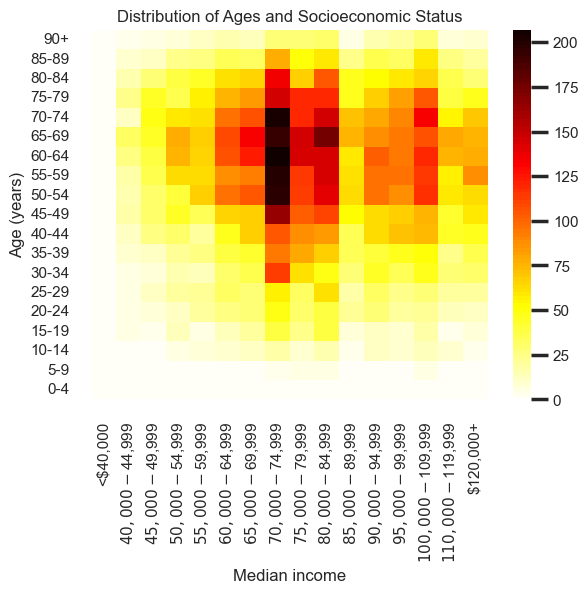

In [280]:
# Heatmap of age and socioeconomic
sns.set_context('poster',font_scale=.5)
# Create a pivot table that calculates the count of occurrences for each age and SES combination
# 
heatmap_data = filtered_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)

# Generate the RdYlGn palette with a specific number of colors
palette = sns.color_palette("hot_r",n_colors=100)
# Remove the darkest green, which is typically the last color in the RdYlGn palette
# You can adjust the indices depending on which colors you want to remove
# modified_palette = palette[:-1]  # This removes the last color

# Convert the modified list of colors to a colormap
cmap = sns.color_palette(palette, as_cmap=True)

# Create the heatmap
ses_heat = sns.heatmap(heatmap_data, cmap=cmap, annot=False, fmt='d')
ses_heat.invert_yaxis()
plt.title('Distribution of Ages and Socioeconomic Status')
plt.xlabel('Median income')
plt.ylabel('Age (years)')
# plt.show()
# Rotate the y-axis labels
plt.yticks(rotation=0)  # Rotate y-axis labels to be horizontal (90º from the default)
# plt.close()

# Determine Histological Characterization + Order

In [285]:
# Histology order - Manually Defined and dependent on each dataset
histology_order = ['Adenocarcinoma','Adenoid Cystic Carcinoma','Mucoepidermoid Carcinoma','Other Rare Types','Mixed Subtypes']

# Categorize Histology column based on pre-ordained order
filtered_df['Histology'] = pd.Categorical(filtered_df['Histology'],categories=histology_order, ordered=True)

# For plotting FacetGrid determine the top N types
tumor_type_counts = filtered_df['Histology'].value_counts(normalize=True)
ordered_counts = tumor_type_counts[histology_order]
ordered_labels = histology_order # top cancers

# Pick top N cancers for plotting
N = 3
topCancerTypes = ordered_labels[0:N]
print(topCancerTypes)
filtered_df_forFacetGrid = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]

filtered_df_forFacetGrid['Histology'] = filtered_df_forFacetGrid['Histology'].cat.remove_unused_categories()

# Color Set Up
colors = ['#FFB200', '#30B7AE', '#BFEF8E','#ffabab','#96f1ff'] # Basic Colors

fullColorDict = dict(zip(histology_order,colors))
topNColorDict = dict(zip(topCancerTypes,colors[0:N]))

fullColorDict

['Adenocarcinoma', 'Adenoid Cystic Carcinoma', 'Mucoepidermoid Carcinoma']


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/1147726711.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forFacetGrid['Histology'] = filtered_df_forFacetGrid['Histology'].cat.remove_unused_categories()


{'Adenocarcinoma': '#FFB200',
 'Adenoid Cystic Carcinoma': '#30B7AE',
 'Mucoepidermoid Carcinoma': '#BFEF8E',
 'Other Rare Types': '#ffabab',
 'Mixed Subtypes': '#96f1ff'}

## Distribution by Age & Pie Plot

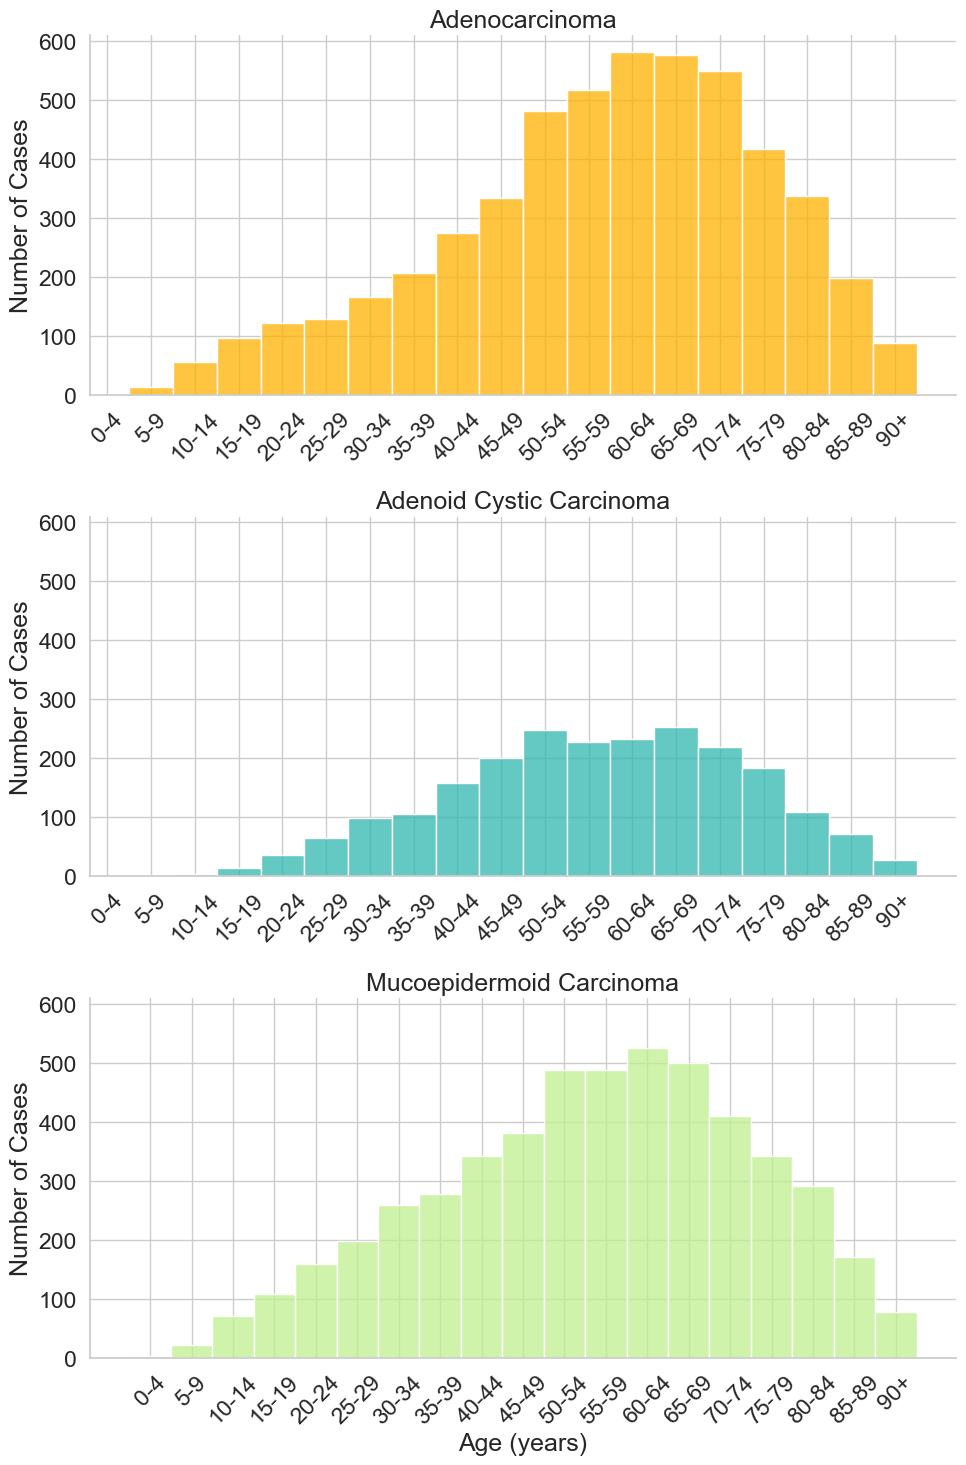

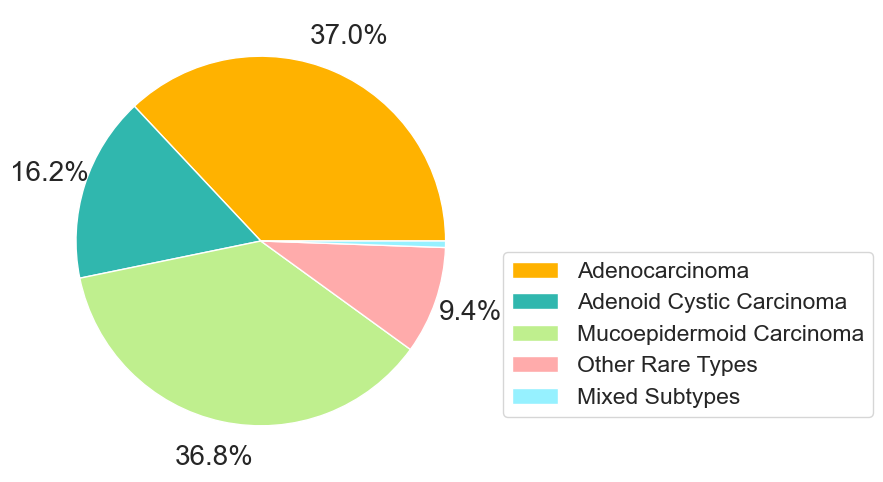

In [286]:
# Set the context for better visibility
sns.set_context("notebook", font_scale=1.5)

# Create a FacetGrid instead of using displot
g = sns.FacetGrid(filtered_df_forFacetGrid, col="Histology", col_wrap=1, height=5, aspect=2, sharex=False)
g.map_dataframe(sns.histplot, x=age_bin_colname, binwidth=1, hue='Histology', palette=topNColorDict, multiple='stack')

# Rotate the x-tick labels in each facet
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set labels and titles
g.set_xlabels('Age (years)')
g.set_ylabels('Number of Cases')
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

# Calculate tumor site counts
tumor_type_counts = filtered_df['Histology'].value_counts(normalize=True)
ordered_counts = tumor_type_counts[histology_order]
ordered_labels = histology_order

labels = tumor_type_counts.index

# Create pie chart
plt.figure(figsize=(8, 6))
# Explicit colors definition:
colors_for_pie = [fullColorDict[label] for label in ordered_labels if label in fullColorDict]
# Define a function as an input to autopct:
def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct >= 1 else ''

# Create the pie chart with specified font sizes
patches, texts, autotexts = plt.pie(
    ordered_counts, labels=None, autopct=autopct_format,
    pctdistance=1.2, colors=colors_for_pie
)

# Adjust the font size for the pie chart
for text in texts:
    text.set_fontsize(16)
for autotext in autotexts:
    autotext.set_fontsize(20)

# Add legend
plt.legend(patches, ordered_labels, loc='best', bbox_to_anchor=(1, 0.5))

plt.show()


## Cancer Types and Year of Diagnosis

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/3371906136.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_year_counts = filtered_df.groupby('Histology')['Year of diagnosis'].value_counts()


,Year of diagnosis,Total Counts
16,2000,579
21,2001,517
19,2002,539
20,2003,518
14,2004,594
18,2005,572
13,2006,628
17,2007,573
7,2008,657
15,2009,588


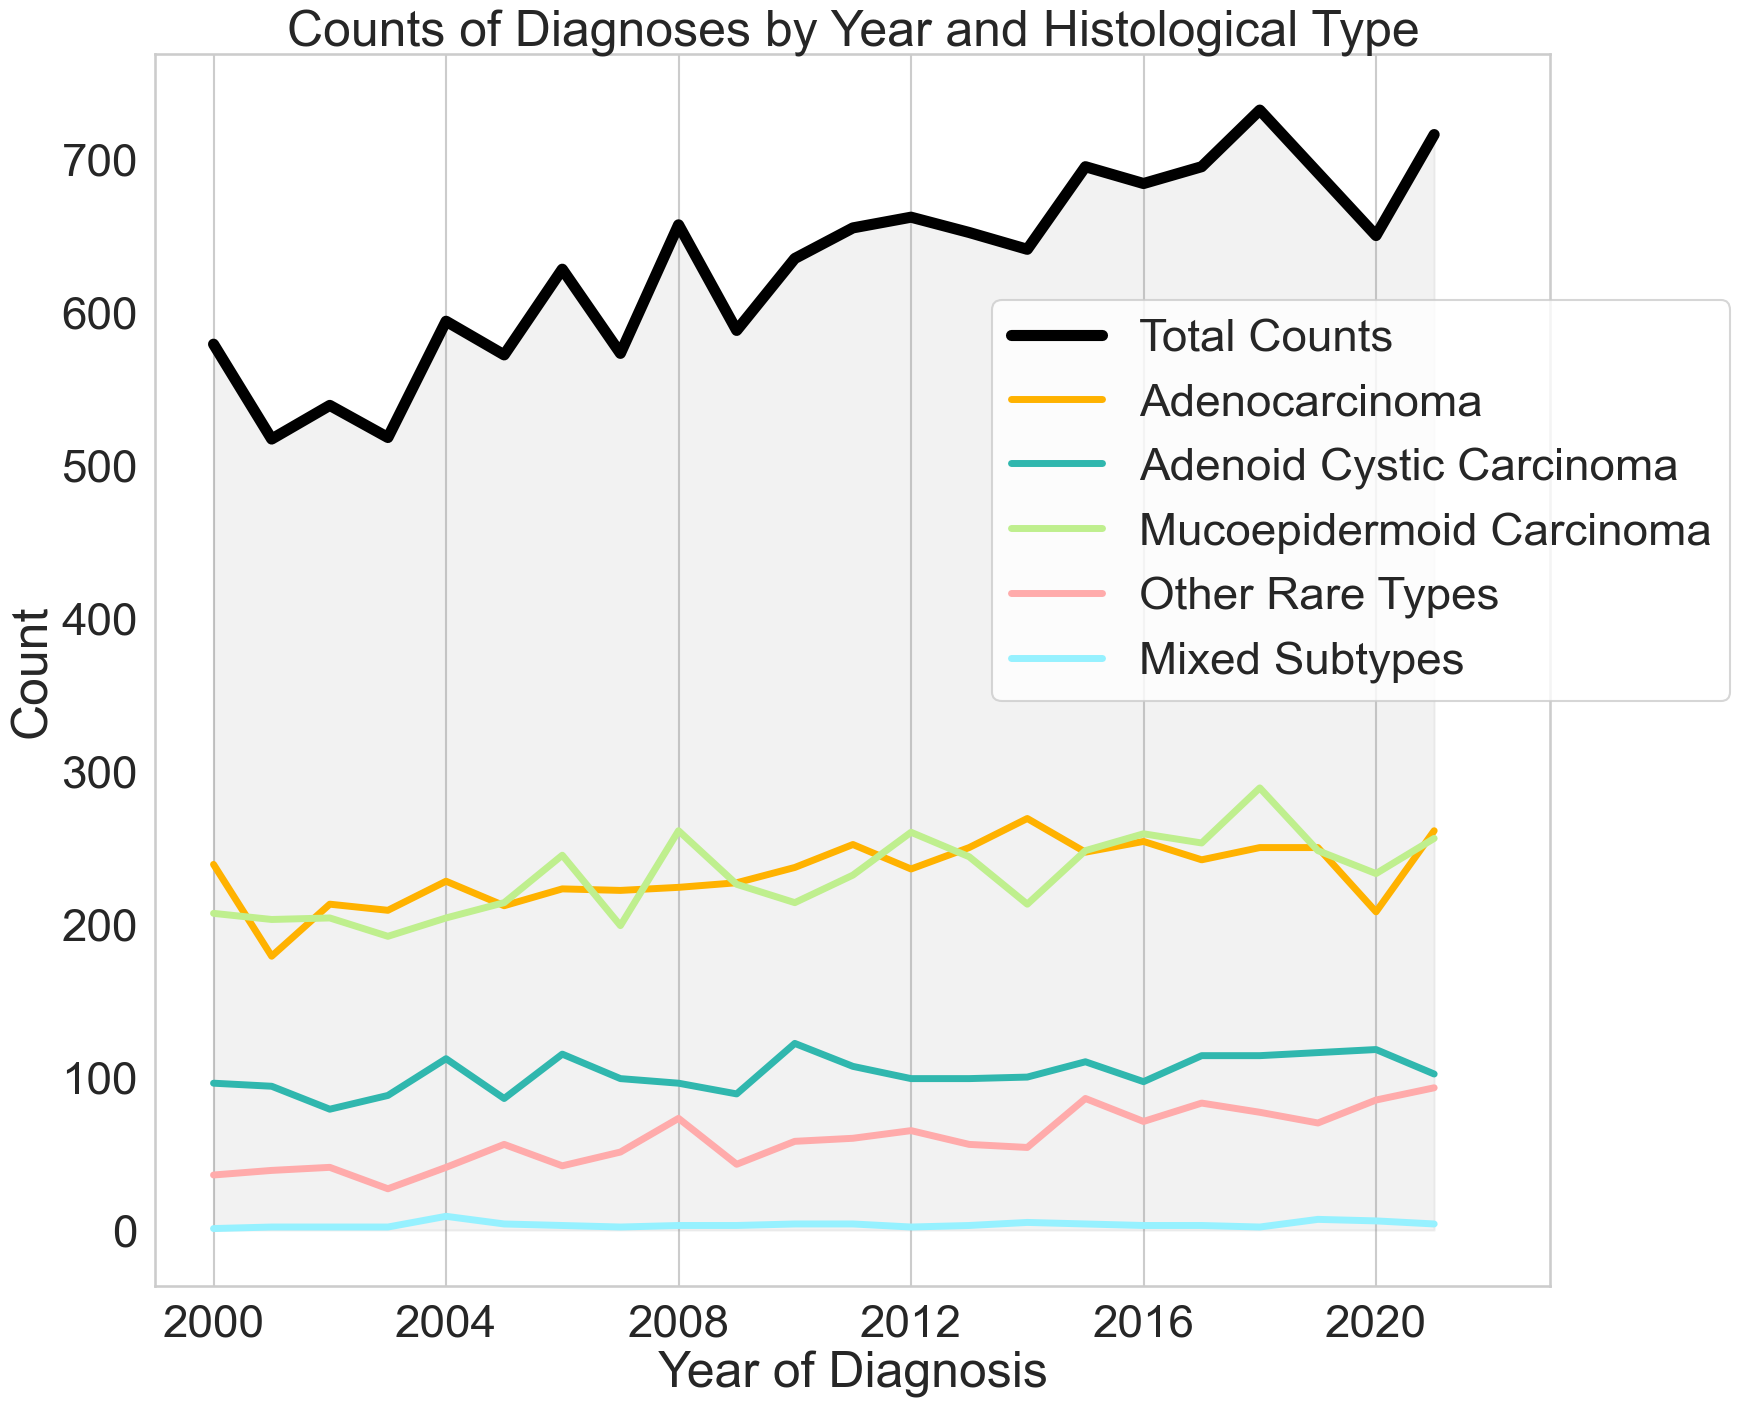

In [336]:
# Calculate counts per year per histological type.
type_year_counts = filtered_df.groupby('Histology')['Year of diagnosis'].value_counts()
type_year_counts_df = type_year_counts.reset_index(name='Counts')

# Calculate the counts per year for the bar plot
year_counts = filtered_df['Year of diagnosis'].value_counts()
year_counts_df = year_counts.reset_index(name='Total Counts')
year_counts_df.columns = ['Year of diagnosis', 'Total Counts']

# Ensure 'Year of diagnosis' is treated as an integer
year_counts_df['Year of diagnosis'] = year_counts_df['Year of diagnosis'].astype(int)
type_year_counts_df['Year of diagnosis'] = type_year_counts_df['Year of diagnosis'].astype(int)

# Sort both dataframes by 'Year of diagnosis' to ensure proper plotting order
year_counts_df = year_counts_df.sort_values('Year of diagnosis')
type_year_counts_df = type_year_counts_df.sort_values('Year of diagnosis')

# Display for verification
display(year_counts_df)

# Create plot and aesthetics
plt.figure(figsize=(18,16))
sns.set_context('talk', font_scale=2)

# Create the bar plot in the background for total counts per year
# sns.lineplot(year_counts_df,x='Year of diagnosis',y='Total Counts',
#              color=(0,0,0),lw=8,zorder=1,label='Total Count')
# Create the line plot for total counts per year
# We're using plt.plot instead of sns.lineplot to have more control over shading
plt.plot(year_counts_df['Year of diagnosis'], year_counts_df['Total Counts'],
         color='black', label='Total Counts', lw=8)

# Fill the area under the line with a shaded color
plt.fill_between(year_counts_df['Year of diagnosis'], year_counts_df['Total Counts'],
                 color='grey', alpha=0.1)

# Create line plot for each individual histological type
sns.lineplot(type_year_counts_df,x='Year of diagnosis',y='Counts',
             palette=colors,hue='Histology',lw=5,zorder=2)

# Adjust the x value limits
plt.xlim(1999,2023)
plt.xticks(range(2000,2022,4))
plt.grid(False, axis='y')
# Adjust legend position and add 'Total Counts' to the legend
plt.legend(bbox_to_anchor=(.6, .8), loc='upper left', borderaxespad=0.)

# Add labels and title
plt.xlabel('Year of Diagnosis')
plt.ylabel('Count')
plt.title('Counts of Diagnoses by Year and Histological Type')

plt.show()

# Age, Race, and Sex Proportions & Distributions

## Generate Excel files

In [279]:
# Calculate counts (value_counts with normalized=False) and sort (sort_index())
colsForTables = [age_bin_colname,sex_colname,race_colname,ses_colname,'Grade Label']
# Create an Excel writer object and specify the file path
output_file_path = 'merged_tables.xlsx'
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    for col in colsForTables:
        counts = (filtered_df[col].
                  value_counts(normalize=False).
                  sort_index())

        # Calculate proportions (normalized=True), sort (sort_index()), convert to indices
        proportions = (filtered_df[col].
                       value_counts(normalize=True).
                       sort_index())

        # Merge the counts and proportions into one table
        merged_table = pd.DataFrame({'Counts': counts, 'Proportions': proportions})

        # Write each DataFrame to a different sheet
        merged_table.to_excel(writer, sheet_name=col[:30])

        # Create a pivot table for counts
        counts_table = filtered_df.pivot_table(
            index=col,      # Rows (e.g., Age)
            columns='Histology',        # Columns (e.g., Histology categories)
            aggfunc='size',            # Aggregation function (count in this case)
            fill_value=0                # Fill missing values with 0
        )

        counts_table.to_excel(writer, sheet_name=col[:20]+'_wide')

    
print(f"Merged tables exported to {output_file_path}")

Merged tables exported to merged_tables.xlsx


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/2726219058.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/2726219058.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/2726219058.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/

# Survival Analysis

### Data Preparation and Clinical Column Identification

In [337]:
# Select relevant columns for clinical characteristics analysis
clinical_columns = ['Primary Site - labeled', 'Histologic Type ICD-O-3',
                     'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
                     'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Grade Label', 'Laterality',
                     'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
                     'ICD-O-3 Hist/behav, malignant','Histology','ICD-O-3 Code','SEER cause-specific death classification',
                    'SEER other cause of death classification', 'Survival months',
                    'Survival months flag', 'COD to site rec KM',
                    'COD to site recode ICD-O-3 2023 Revision',
                    'COD to site recode ICD-O-3 2023 Revision Expanded (1999+)',
                    'Vital status recode (study cutoff used)', 'Sequence number',
                    'First malignant primary indicator', 'Primary by international rules']

# Creating a summary for clinical characteristics
clinical_summary = filtered_df[clinical_columns]

# Display the summary
# display(clinical_summary)

vital_percentages = clinical_summary["Vital status recode (study cutoff used)"].value_counts(normalize=True) * 100
alive_percentage = vital_percentages["Alive"]
dead_percentage = vital_percentages["Dead"]

print(vital_percentages)

Vital status recode (study cutoff used)
Alive    64.362431
Dead     35.637569
Name: proportion, dtype: float64


## Kaplan Meier Survival Curves Figures

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/759509099.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()


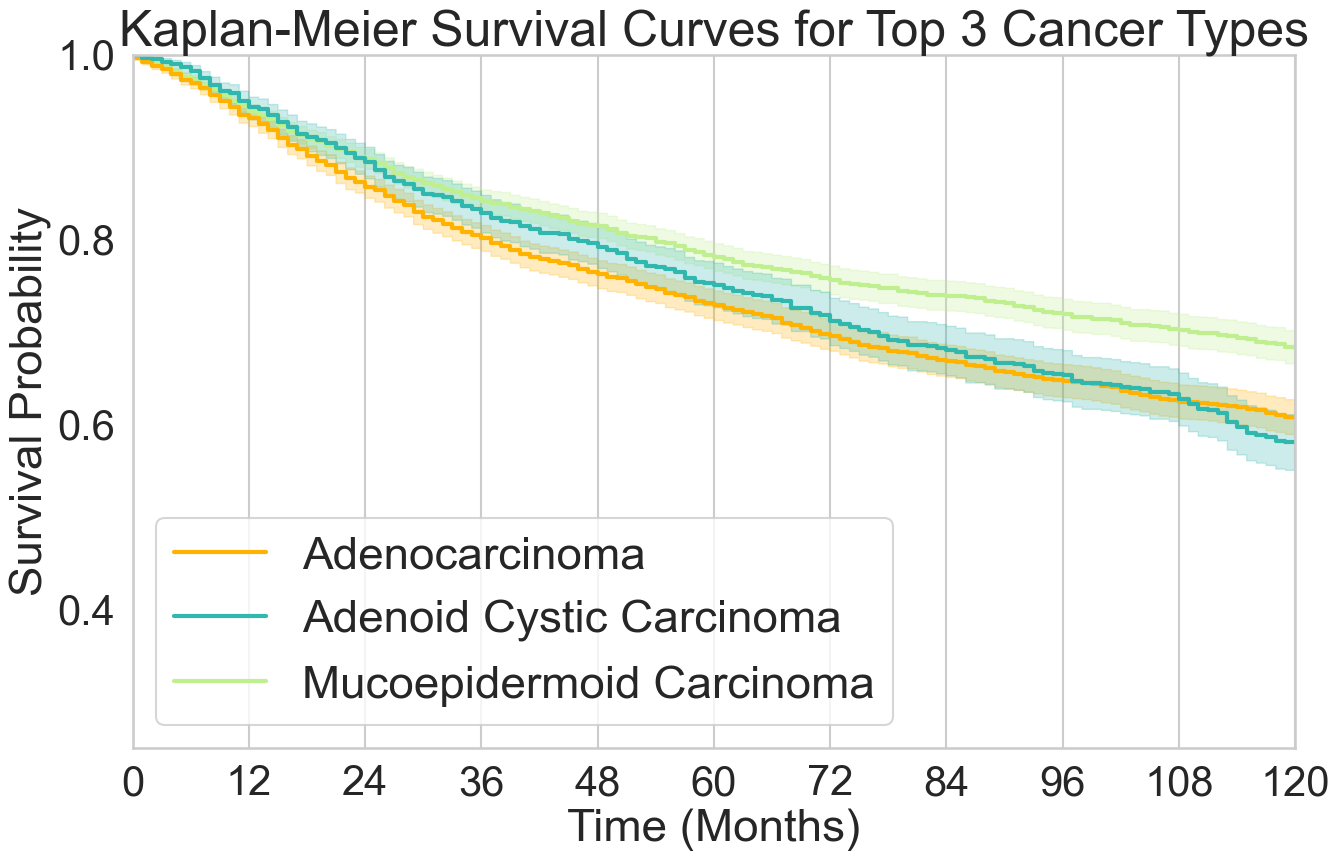

<Figure size 640x480 with 0 Axes>

In [338]:
# Replace "Unknown" with nan's 
filtered_df['Survival months'] = filtered_df['Survival months'].replace("Unknown", np.nan)
# Change to numeric
filtered_df['Survival months'] = pd.to_numeric(filtered_df['Survival months'])

filtered_df['event_occurred'] = filtered_df['Vital status recode (study cutoff used)'].apply(
    lambda x: 1 if x == 'Dead'
# else 2 if x == 'Dead (missing/unknown COD)'
else 0)

# Focus analysis on top cancers
filtered_df_forKM = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]
filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()

df = filtered_df_forKM.dropna()
# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique cancer types in your dataset
cancer_types = df['Histology'].unique()

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for cancer_type in cancer_types:
    # Filter the DataFrame for each cancer type
    df_cancer = df[df['Histology'] == cancer_type]
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_cancer['Survival months'], event_observed=df_cancer['event_occurred'], label=cancer_type)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=topNColorDict[cancer_type])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves for Top 3 Cancer Types', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = topCancerTypes

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)

# Show the plot
plt.show()

# Show the plot
plt.tight_layout()
plt.show()

# Cox Hazard Ratio

### Data Preparation including one-hot encoding and addressing collinearities

In [339]:
# Filter the dataset to include only relevant columns for the Cox model
cols_Tx = ['RX Summ--Scope Reg LN Sur (2003+)', 'RX Summ--Surg Oth Reg/Dis (2003+)', 'RX Summ--Surg/Rad Seq', 'Reason no cancer-directed surgery', 'Radiation recode', 'Chemotherapy recode (yes, no/unk)', 'RX Summ--Systemic/Sur Seq (2007+)']
cox_df_updated = filtered_df_forKM[['Survival months', 'event_occurred', 'Age recode with single ages and 90+', 'Sex','Histology','Grade Label','Median household income inflation adj to 2022'] + cols_Tx]
cox_df_updated = cox_df_updated[cox_df_updated['Survival months'] <= 120]

# Handle special cases in various columns
age_replacement = {'≤1': '1', '90+': '90'}  # Replace special cases for age
cox_df_updated['Age recode with single ages and 90+'] = cox_df_updated['Age recode with single ages and 90+'].replace(age_replacement).astype(float)

# Drop rows where required fields are missing (e.g., Survival months or event_occurred)
cox_df_updated = cox_df_updated.dropna(subset=['Survival months', 'event_occurred','Median household income inflation adj to 2022'])

### Simplify Treatment rows ###
# Define your map for LYMPH NODE REMOVAL
scopeSurgMap = {
    '4 or more regional lymph nodes removed': 'Lymph Nodes Removed',
    '1 to 3 regional lymph nodes removed': 'Lymph Nodes Removed',
    'Sentinel node biopsy and lym nd removed same/unstated time': 'Lymph Nodes Removed',
    'Sentinel node biopsy and lym nd removed different times': 'Lymph Nodes Removed'
}
# Apply the mapping and fill the rest with "Lymph nodes not removed/Unknown"
cox_df_updated['RX Summ--Scope Reg LN Sur recode'] = cox_df_updated['RX Summ--Scope Reg LN Sur (2003+)'].map(scopeSurgMap).fillna("Lymph Nodes Removed: No/Unknown")
cox_df_updated['RX Summ--Scope Reg LN Sur recode'] = pd.Categorical(cox_df_updated['RX Summ--Scope Reg LN Sur recode'],
                                                                    categories=['Lymph Nodes Removed: No/Unknown','Lymph Nodes Removed'],
                                                                    ordered=True)

# Define your map for RADIATION WITH/WITHOUT SURGERY
# cox_df_updated['RX Summ-Surg/Rad Seq recode'] = cox_df_updated['RX Summ--Surg/Rad Seq'].apply(
#     lambda x: 'No radiation' if x == 'No radiation and/or no surgery; unknown if surgery and/or radiation given' else 'Surgery and radiation'
# )
# cox_df_updated['RX Summ-Surg/Rad Seq recode'] = pd.Categorical(cox_df_updated['RX Summ-Surg/Rad Seq recode'],
#                                                                categories=['No radiation','Surgery and radiation'],
#                                                                ordered=True)

# Defined your map for 'Reason no cancer-directed surgery' Surgery performed? Yes/No/Unknown simplification
surgPerformedMap = {'Surgery performed':'Surgery: Yes',
                    'Not recommended':'Surgery: No',
                    'Not recommended, contraindicated due to other cond; autopsy only (1973-2002)':'Surgery: No',
                    'Recommended but not performed, unknown reason':'Surgery: No',
                    'Recommended but not performed, patient refused':'Surgery: No',
                    'Not performed, patient died prior to recommended surgery':'Surgery: No'}

# Apply the mapping; fill the rest with "Unknown if surgery performed"
cox_df_updated['Reason no cancer-directed surgery recode'] = cox_df_updated['Reason no cancer-directed surgery'].map(surgPerformedMap).fillna('Surgery: Unknown')
cox_df_updated['Reason no cancer-directed surgery recode'] = pd.Categorical(cox_df_updated['Reason no cancer-directed surgery recode'],
                                                                            categories=['Surgery: No','Surgery: Yes','Surgery: Unknown'],
                                                                            ordered=True)

# Define and apply radiation recode mapping 
radiationTypeMap = {'None/Unknown':'Radiotherapy: Unknown',
                    'Refused (1988+)': 'Radiotherapy: No',
                    'Recommended, unknown if administered': 'Radiotherapy: Unknown'}
cox_df_updated['Radiation recode recode'] = cox_df_updated['Radiation recode'].map(radiationTypeMap).fillna('Radiotherapy: Yes')

cox_df_updated['Radiation recode recode'] = pd.Categorical(cox_df_updated['Radiation recode recode'],
                                                           categories=['Radiotherapy: No','Radiotherapy: Yes','Radiotherapy: Unknown'],
                                                           ordered=True)

# Defined systemic therapy recode mapping
systemicMap = {'No systemic therapy and/or surgical procedures': 'No systemic therapy',
               'Blank(s)': 'Unknown'}

# 
cox_df_updated['RX Summ--Systemic/Sur Seq recode'] = cox_df_updated['RX Summ--Systemic/Sur Seq (2007+)'].map(systemicMap).fillna('')

cox_df_updated['RX Summ--Systemic/Sur Seq recode'] = pd.Categorical(cox_df_updated['RX Summ--Systemic/Sur Seq recode'],
                                                                    categories=['No systemic therapy','Systemic therapy and surgery'],
                                                                    ordered=True)
# Drop original + unnecessary columns from Cox PH df 
cox_df_updated.drop(cols_Tx,axis=1,inplace=True)

# Define a function to extract numerical values from median income
def extract_midpoint(income_str):
    # Check if the income string represents an open-ended range (e.g., "$120,000+")
    income_str = income_str.replace(',','')
    if '+' in income_str:
        # Extract the number before the '+' and return it as a float
        return float(re.sub(r'[^\d]', '', income_str))

    # Check if the income string represents a range (e.g., "$40,000 - $44,999")
    elif '-' in income_str:
        # Extract the two numbers and calculate the midpoint
        numbers = re.findall(r'\d+', income_str)
        lower_bound = float(numbers[0])
        upper_bound = float(numbers[1])
        midpoint = (lower_bound + upper_bound) / 2
        return midpoint

    # For exact values (e.g., '<$40,000'), treat it as the lower bound (40,000)
    elif '<' in income_str:
        # Extract the number and treat it as the threshold value
        return float(re.sub(r'[^\d]', '', income_str))

    # If the string does not match any of the patterns, return NaN
    return np.nan

# Apply the function to the income column
cox_df_updated['Income_numeric'] = cox_df_updated['Median household income inflation adj to 2022'].apply(extract_midpoint)

# Ensure the 'Income_numeric' column is converted to a numeric type
cox_df_updated['Income_numeric'] = pd.to_numeric(cox_df_updated['Income_numeric'], errors='coerce')

# Set the median threshold based on 2022 numbers
median_income_threshold = 77540

# Create a new column based on the comparison with the median
cox_df_updated['Income_above_below_median'] = np.where(
    cox_df_updated['Income_numeric'] > median_income_threshold,
    'Above median',
    'Below median'
)

# Get rid of old median income columns
cox_df_updated.drop(['Median household income inflation adj to 2022','Income_numeric'],axis=1,inplace=True)


# Apply One Hot Encoding for Cox PH Analysis
cox_df_updated_encoded = pd.get_dummies(cox_df_updated, columns=[
    'Sex', 'Histology', 'Grade Label', 'RX Summ--Scope Reg LN Sur recode',
    'Reason no cancer-directed surgery recode',
    'Radiation recode recode', 'RX Summ--Systemic/Sur Seq recode',
    'Income_above_below_median'], drop_first=True)

# Drop any remaining rows with missing values
cox_df_updated_encoded = cox_df_updated_encoded.dropna()

# Check the correlation between variables (only numerical columns)
correlation_matrix = cox_df_updated_encoded.corr()
# Drop any remaining rows with missing values
cox_df_updated_encoded = cox_df_updated_encoded.dropna()

cox_df_updated_encoded.drop('Age recode with single ages and 90+', axis=1, inplace=True)

# Display high correlations (e.g., above 0.8)
high_corr = correlation_matrix[(correlation_matrix > 0.75) & (correlation_matrix < 1)].stack()
if high_corr.empty:
    print('Multicollinearities not likely')
else:
    print(high_corr) 

Multicollinearities not likely


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_90412/3870381491.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  cox_df_updated['Age recode with single ages and 90+'] = cox_df_updated['Age recode with single ages and 90+'].replace(age_replacement).astype(float)


In [340]:
# Check for sparse variables (columns with many zeros)
sparsity_check = (cox_df_updated_encoded == 0).sum() / len(cox_df_updated_encoded)
print(sparsity_check[sparsity_check > 0.9])

cox_df_updated_encoded.drop(['Grade Label_Grade IV','Reason no cancer-directed surgery recode_Surgery: Unknown','RX Summ--Systemic/Sur Seq recode_Systemic therapy and surgery'],axis=1,inplace=True)

Grade Label_Grade IV                                             0.924745
Reason no cancer-directed surgery recode_Surgery: Unknown        0.994256
RX Summ--Systemic/Sur Seq recode_Systemic therapy and surgery    1.000000
dtype: float64


###  Model Fitting

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Sex_Male,0.151036,1.163039,0.018153,0.115458,0.186615,1.122387,1.205163,0.0,8.320312,8.773194e-17,53.339675
Histology_Adenoid Cystic Carcinoma,0.002789,1.002793,0.023395,-0.043065,0.048642,0.957849,1.049845,0.0,0.119206,9.051120e-01,0.143832
Histology_Mucoepidermoid Carcinoma,-0.067357,0.934862,0.018743,-0.104092,-0.030621,0.901142,0.969843,0.0,-3.593729,3.259790e-04,11.582934
Grade Label_Grade II,-0.162548,0.849975,0.023415,-0.208441,-0.116655,0.811849,0.889892,0.0,-6.942002,3.865811e-12,37.912366
Grade Label_Grade III,0.340114,1.405108,0.026970,0.287254,0.392973,1.332763,1.481379,0.0,12.610985,1.836835e-36,118.712189
Grade Label_Unknown,-0.022871,0.977388,0.018668,-0.059461,0.013718,0.942272,1.013813,0.0,-1.225133,2.205250e-01,2.180986
RX Summ--Scope Reg LN Sur recode_Lymph Nodes Removed,-0.127304,0.880466,0.018326,-0.163222,-0.091387,0.849403,0.912665,0.0,-6.946813,3.736309e-12,37.961523
Reason no cancer-directed surgery recode_Surgery: Yes,-0.398979,0.671005,0.028213,-0.454275,-0.343683,0.634908,0.709153,0.0,-14.141788,2.098827e-45,148.417181
Radiation recode recode_Radiotherapy: Yes,0.080693,1.084038,0.018997,0.043459,0.117926,1.044417,1.125161,0.0,4.247644,2.160302e-05,15.498408


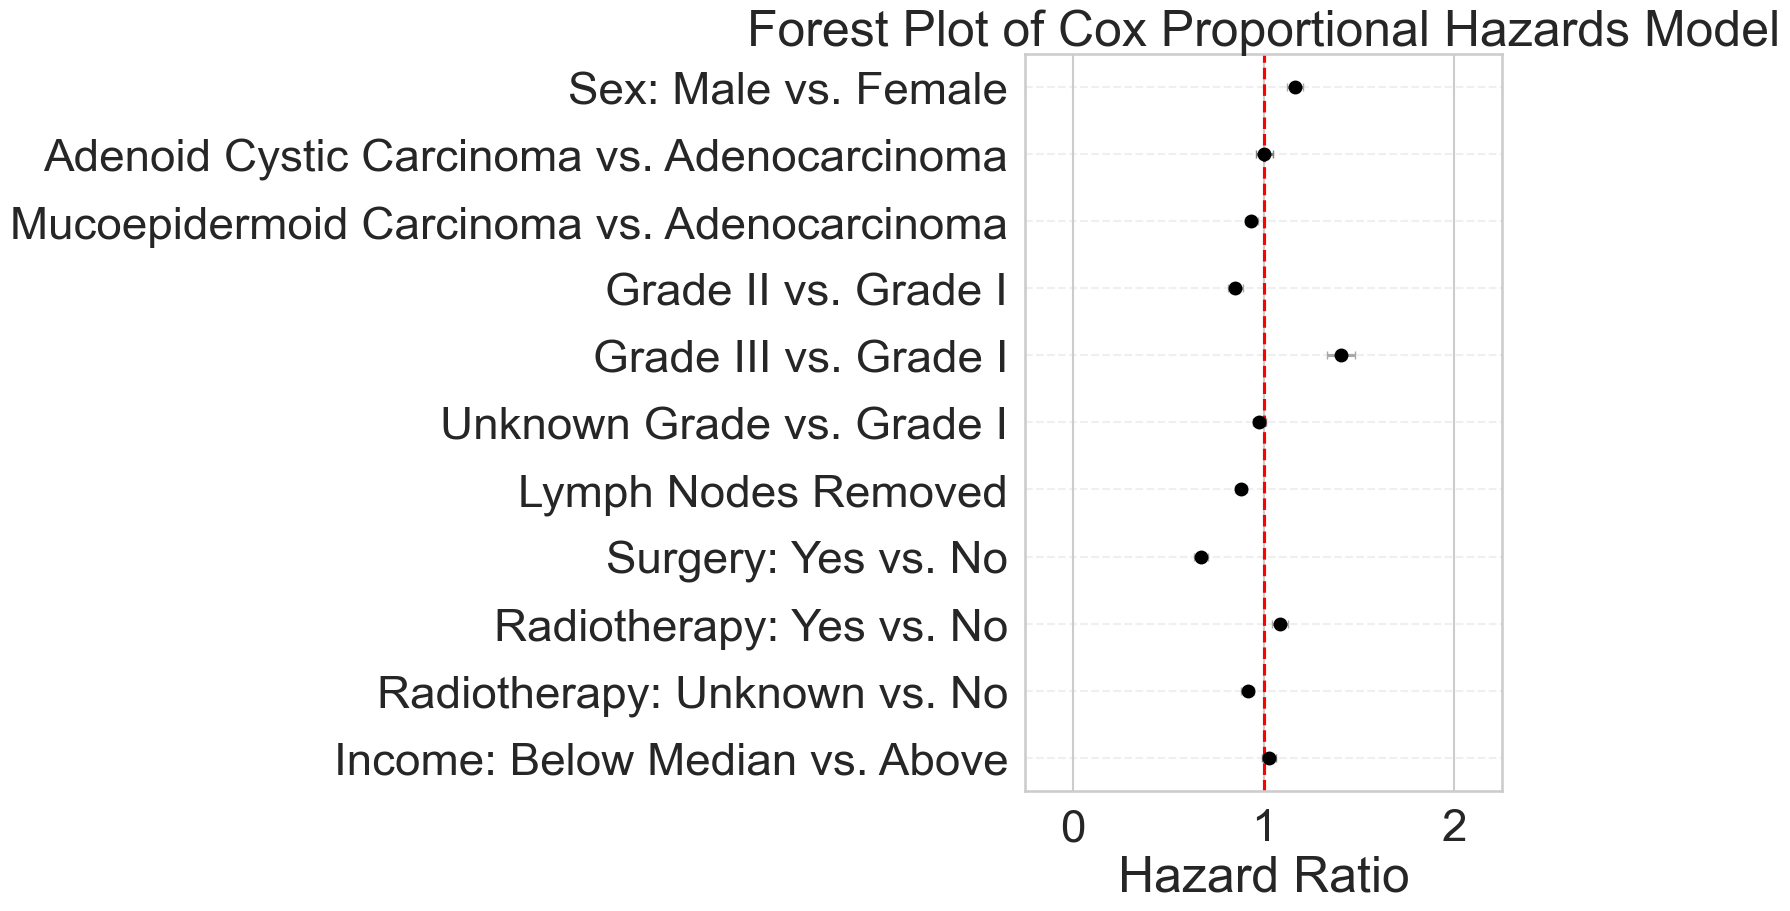

In [343]:
# Fit Cox model
cox_model = CoxPHFitter(penalizer=1.0)
cox_model.fit(cox_df_updated_encoded, duration_col='Survival months', event_col='event_occurred')

# Export summary
cox_summary = cox_model.summary
output_file_path = 'cox_model_summary.xlsx'
cox_summary.to_excel(output_file_path)

# Extract coefficients, confidence intervals, and p-values
coef = cox_model.summary['coef']
lower_ci = cox_model.summary['coef lower 95%']
upper_ci = cox_model.summary['coef upper 95%']
p_values = cox_model.summary['p']
variables = coef.index

display(cox_summary)
cox_summary
# Labels
new_labels = {
    'Sex_Male': 'Sex: Male vs. Female',
    'Histology_Adenoid Cystic Carcinoma': 'Adenoid Cystic Carcinoma vs. Adenocarcinoma',
    'Histology_Mucoepidermoid Carcinoma': 'Mucoepidermoid Carcinoma vs. Adenocarcinoma',
    'Grade Label_Grade II': 'Grade II vs. Grade I',
    'Grade Label_Grade III': 'Grade III vs. Grade I',
    'Grade Label_Unknown':'Unknown Grade vs. Grade I',
    'RX Summ--Scope Reg LN Sur recode_Lymph Nodes Removed': 'Lymph Nodes Removed',
    'Reason no cancer-directed surgery recode_Surgery: Yes': 'Surgery: Yes vs. No',
    'Radiation recode recode_Radiotherapy: Yes': 'Radiotherapy: Yes vs. No',
    'Radiation recode recode_Radiotherapy: Unknown': 'Radiotherapy: Unknown vs. No',
    'Income_above_below_median_Below median': 'Income: Below Median vs. Above'
}

# Define the order and reverse it
order = [
    'Sex_Male',
    'Histology_Adenoid Cystic Carcinoma',
    'Histology_Mucoepidermoid Carcinoma',
    'Grade Label_Grade II',
    'Grade Label_Grade III',
    'Grade Label_Unknown',
    'RX Summ--Scope Reg LN Sur recode_Lymph Nodes Removed',
    'Reason no cancer-directed surgery recode_Surgery: Yes',
    'Radiation recode recode_Radiotherapy: Yes',
    'Radiation recode recode_Radiotherapy: Unknown',
    'Income_above_below_median_Below median'
    ]
order = order[::-1]

# Reorder coefficients and confidence intervals and convert to hazard ratios
coefficients_ordered = np.exp(np.array([coef[label] for label in order]))
lower_ci_ordered = np.exp(np.array([lower_ci[label] for label in order]))
upper_ci_ordered = np.exp(np.array([upper_ci[label] for label in order]))

# Highlight significant p-values
significant = p_values < 0.05

# Error bars
errors_ordered = [coefficients_ordered - lower_ci_ordered, upper_ci_ordered - coefficients_ordered]

# Plot setup
fig, ax = plt.subplots(figsize=(16, 10))

# Plot with significant points highlighted
for i, label in enumerate(order):
    if significant[label]:
        plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
                     fmt='o', color='black', ecolor='darkgrey', capsize=3)  # Significant in red
    else:
        plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
                     fmt='o', color='black', ecolor='grey', capsize=3)

# Add a vertical line for hazard ratio = 1
plt.axvline(x=1, color='red', linestyle='--')

# Update the y-tick labels to the new labels, in the specified order
ax.set_yticks(range(len(order)))
ax.set_yticklabels([new_labels[label] for label in order])

# Set X-axis
plt.xlim(-.25,2.25)

# Customize the plot
plt.xlabel('Hazard Ratio')
plt.title('Forest Plot of Cox Proportional Hazards Model')

# Add gridlines for y-axis (horizontal lines)
ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('cox_forest_plot.png', dpi=300)  # Save the plot as a PNG file

# Show the plot
plt.show()

